The set file is processed by eeglab plugin including re-referrence,line-noice removal using multitaper estimation

In [58]:
import mne
from mne.io import read_raw_eeglab
montage_NE = mne.channels.read_montage(kind='Enobio32',
                                       path=r'F:\software\1NE_NIC2\1channelL')
raw = read_raw_eeglab(r'F:\software\1NE_NIC2\raw\motor_imagine_data\raw_set\subject1_raw_session1.set',montage =montage_NE,preload=True)


Reading F:\software\1NE_NIC2\raw\motor_imagine_data\raw_set\subject1_raw_session1.fdt
Reading 0 ... 449999  =      0.000 ...   899.998 secs...


# pipeline design
- non erp one i.e. continuous signal, segmentation happened before fitting classifier and after preprocess
    - PREP early stage preprocessing pipeline (eeglab)
    - epochs data and perform ica rejection 
        - two options: using MARA(not implemented yet) or not 
- alternative : using rASR in EEGLAB plugin
- we treat data as ERP data = we segment the data before preprocess

Note: event code: rest state:111, attention state: 112, MI state:113

Reading F:\software\1NE_NIC2\raw\motor_imagine_data\raw_set\subject1_raw_session1.fdt
Reading 0 ... 449999  =      0.000 ...   899.998 secs...
Used Annotations descriptions: ['1', '111', '112', '113']
100 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 100 events and 1101 original time points ...
0 bad epochs dropped


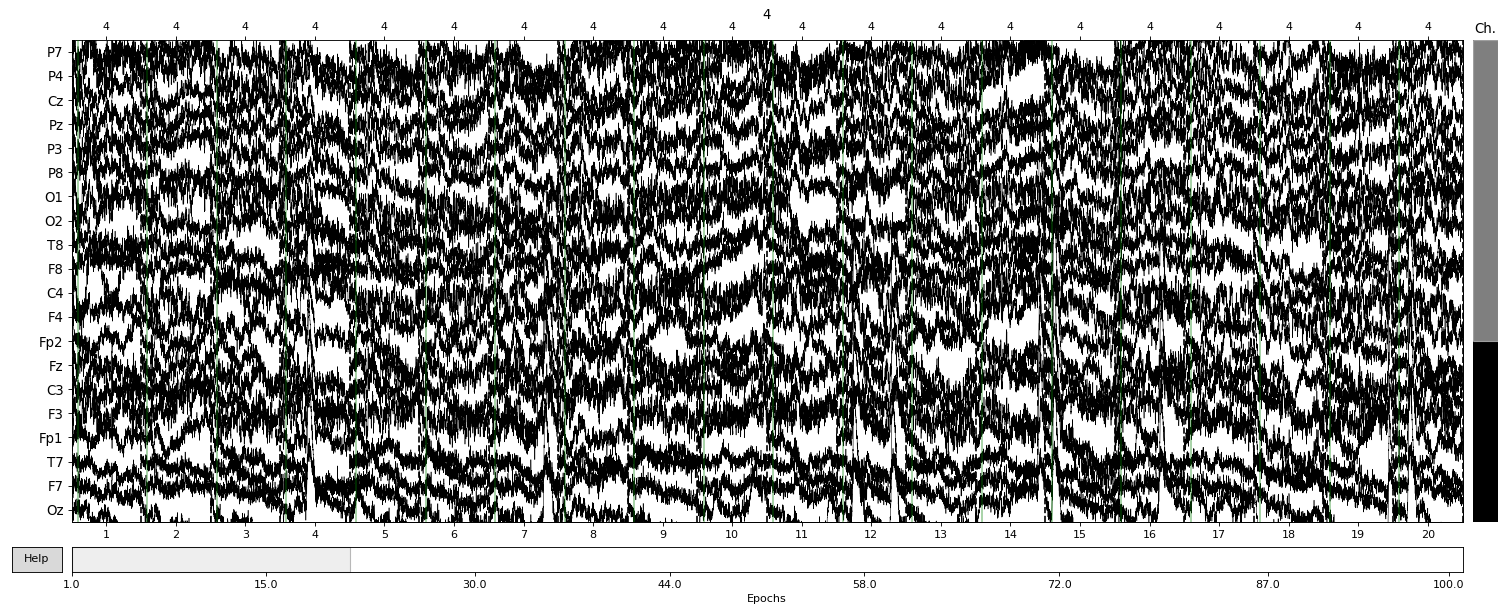

In [25]:
# original event = mark the begining, in this section we create epochs and perform ICA
import numpy as np
import mne
from mne.io import read_raw_eeglab
montage_NE = mne.channels.read_montage(kind='Enobio32',
                                       path=r'F:\software\1NE_NIC2\1channelL')
raw = read_raw_eeglab(r'F:\software\1NE_NIC2\raw\motor_imagine_data\raw_set\subject1_raw_session1.set',montage =montage_NE,preload=True)

events_code = {'restState':111,'attentionState':112, 'MIState':113}
delay = 0 # the delay of the begining of the EXP paradigm
srate = 500
trialDuration = 8 # 8 sec for one trial
annotations = raw.annotations.copy()
begin_time = annotations.__getitem__(0)['onset']
segmentEnd_time = begin_time#initialization end_sample: the sample number at the end of one segment
event_id = {'111':111,'112':112,'113':113}

for i in range(100):
    annotations.append(segmentEnd_time+1,0,112)
    annotations.append(segmentEnd_time+3,0,113)
    annotations.append(segmentEnd_time+7,0,111)
    segmentEnd_time +=trialDuration
    annotations.append(segmentEnd_time,0,111)
raw.set_annotations(annotations)
events, event_id = mne.events_from_annotations(raw)
#event_id = {'1':1,'111':111,'112':112,'113':113}
epochs = mne.Epochs(raw,events,event_id=event_id['113'],tmax=2,preload=True)
epochs.plot()

In [6]:
epochs.get_data()

Loading data for 100 events and 1101 original time points ...


array([[[ 1.90759398e-06,  7.86853148e-06,  9.58435179e-06, ...,
          1.07298596e-05,  9.58435179e-06,  6.81970336e-06],
        [ 1.52784653e-06,  5.96241685e-06,  8.91847153e-06, ...,
          2.82309715e-05,  3.08540184e-05,  2.80395653e-05],
        [-2.36724551e-06, -5.54745514e-07,  1.20892636e-06, ...,
          1.83280670e-05,  1.54188873e-05,  1.28915435e-05],
        ...,
        [-2.80395266e-06,  1.62964109e-06,  3.49096921e-06, ...,
         -3.32934329e-06, -7.28637454e-06, -1.15793433e-05],
        [ 3.27098159e-06,  7.46629409e-06,  8.94480972e-06, ...,
          3.20717628e-05,  3.25971535e-05,  3.08315285e-05],
        [-1.78383354e-05, -1.15922416e-05, -8.39692915e-06, ...,
          6.29819771e-05,  6.53686959e-05,  6.47007271e-05]],

       [[ 4.87102607e-06, -1.70905206e-06,  1.98174505e-07, ...,
          1.87948542e-05,  2.21327448e-05,  1.78417292e-05],
        [ 5.29158609e-06, -2.52872641e-06, -1.47989828e-06, ...,
          2.83706877e-05,  3.27564298e

In [26]:
from mne.preprocessing import ICA,create_ecg_epochs,create_eog_epochs
reject = dict(eeg=75e-6)
ica = ICA(n_components=0.99, method='fastica',random_state=11).fit(epochs,reject=reject)


try:
    ecg_epochs = create_ecg_epochs(raw, tmin=-.5, tmax=.5)
    ecg_inds, scores = ica.find_bads_ecg(ecg_epochs)
except:
    print("signals without cardial artifact")
%matplotlib qt
ica.plot_components(inst=epochs) 
eog_average = create_eog_epochs(raw,ch_name='Fp1').average()
n_max_eog = 1  # here we bet on finding the vertical EOG components
eog_epochs = create_eog_epochs(raw, ch_name='Fp1')  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs,ch_name='Fp2')  # find via correlation
ica.plot_scores(scores, exclude=eog_inds)
ica.plot_sources(eog_average, exclude=eog_inds)
ica.save(r'F:\software\1NE_NIC2\raw\motor_imagine_data\ica_fif\session1_ica.fif')


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by explained variance: 20 components
Fitting ICA took 1.0s.
signals without cardial artifact
Dropped 0 epochs
Channels marked as bad: []
Using channel Fp1 as EOG channel
EOG channel index for this subject is: [16]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 8192 samples (16.384 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------


<ipython-input-26-1602af8fa910>:19: RuntimeWarning: This filename (F:\software\1NE_NIC2\raw\motor_imagine_data\ica_fif\session1.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(r'F:\software\1NE_NIC2\raw\motor_imagine_data\ica_fif\session1.fif')


<ICA  |  epochs decomposition, fit (fastica): 110100 samples, 20 components, channels used: "eeg">

In [27]:
ica = mne.preprocessing.read_ica(r'F:\software\1NE_NIC2\raw\motor_imagine_data\ica_fif\session1.fif')
ica.exclude=[0,1,2,4,13,15]
ica.apply(inst=epochs)

Reading F:\software\1NE_NIC2\raw\motor_imagine_data\ica_fif\session1.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (20 components)
Zeroing out 6 ICA components


<ipython-input-27-7378672cb68a>:1: RuntimeWarning: This filename (F:\software\1NE_NIC2\raw\motor_imagine_data\ica_fif\session1.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = mne.preprocessing.read_ica(r'F:\software\1NE_NIC2\raw\motor_imagine_data\ica_fif\session1.fif')


<Epochs  |   100 events (all good), -0.2 - 2 sec, baseline [None, 0], ~27.0 MB, data loaded,
 '4': 100>

In [30]:
epochs.plot(n_epochs=5)
epochs.save(r'F:\software\1NE_NIC2\raw\motor_imagine_data\epochs_afterICA\session1_epochs.fif')

<ipython-input-30-855ff88be38e>:2: RuntimeWarning: This filename (F:\software\1NE_NIC2\raw\motor_imagine_data\epochs_afterICA\session1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(r'F:\software\1NE_NIC2\raw\motor_imagine_data\epochs_afterICA\session1_epochs.fif')
<ipython-input-30-855ff88be38e>:2: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  epochs.save(r'F:\software\1NE_NIC2\raw\motor_imagine_data\epochs_afterICA\session1_epochs.fif')


In [21]:
# original event = mark the begining, in this section we create epochs and perform ICA
import numpy as np
events_code = {'restState':111,'attentionState':112, 'MIState':113}
delay = 0 # the delay of the begining of the EXP paradigm
srate = 500
trialDuration = 4000 # 8 sec for one trial
annotations = raw.annotations.copy()
events, event_id = mne.events_from_annotations(raw)
begin_sample = events[0][0]
end_sample = begin_sample#initialization end_sample: the sample number at the end of one segment
event_id = {'111':111,'112':112,'113':113}
mne.events_from_annotations(raw)

for i in range(100):
    annotations.append(end_sample+trialDuration,0,111)
    events = np.vstack((events,np.array([end_sample+trialDuration,0,111])))
    events = np.vstack((events,np.array([end_sample+trialDuration+500,0,112])))
    events = np.vstack((events,np.array([end_sample+trialDuration+1500,0,113])))
    events = np.vstack((events,np.array([end_sample+trialDuration+3500,0,111])))
    end_sample = begin_sample = events[-1][0]

epochs = mne.Epochs(raw, events, [111], baseline=None)

Used Annotations descriptions: ['1']
Used Annotations descriptions: ['1']
200 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [35]:
data, time = epochs[:,:]    
eeg_filepath =r' F:\software\1NE_NIC2\raw\motor_imagine_data\eeglab_mat\session1data.mat'
events_filepath=r' F:\software\1NE_NIC2\raw\motor_imagine_data\eeglab_mat\session1event.mat'
io.savemat(eeg_filepath, dict(data=data), oned_as='row')

IndexError: arrays used as indices must be of integer (or boolean) type

In [44]:
import pandas as pd 
data = epochs.get_data()
#np.savetxt(r'F:\software\1NE_NIC2\raw\motor_imagine_data\epochs_csv\session1.csv', data, fmt="%d", delimiter=",")
#pd.DataFrame(data).to_csv("F:\software\1NE_NIC2\raw\motor_imagine_data\epochs_csv\session1.csv")

import numpy as np


# Write the array to disk
with open(r'F:\software\1NE_NIC2\raw\motor_imagine_data\epochs_csv\session1.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(data.shape))

    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in data:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice)

        # Writing out a break to indicate different slices...
        outfile.write('# New epoch\n')

# processPipeline:
    distinguish MI state from rest state

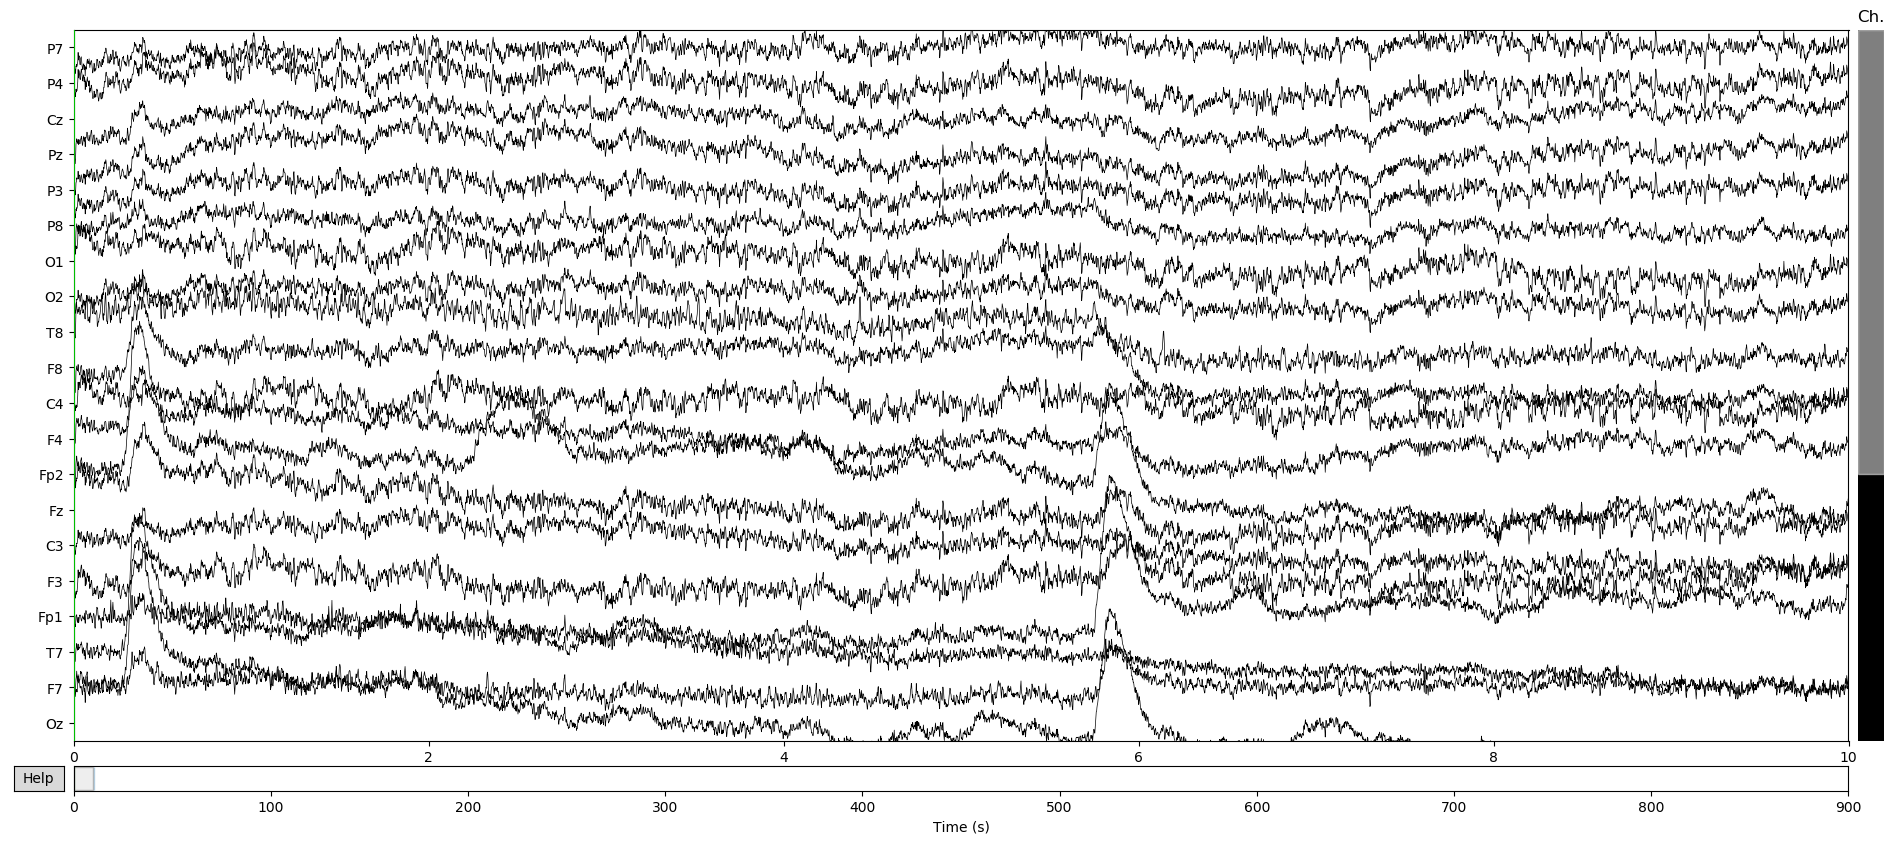

In [7]:
%matplotlib qt
raw.plot()